## Multiple Linear Regression

We seen how to build a model with a target variable based on a single predictor variable. What if we want to include multiple predictor variables?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In this notebook, we'll again work with the possum data.

You can read more about it here: https://www.openintro.org/data/index.php?data=possum

Our goal will be to understand the relationship between the total length in cm (`total_l`) and the other variables in our dataset.

In [2]:
possum = pd.read_csv('../data/possum.csv')

possum.head(2)

,site,pop,sex,age,head_l,skull_w,total_l,tail_l
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5


In [3]:
import statsmodels.formula.api as sm
import statsmodels.api as stats

We've already seen how we can use the head length to estimate the average total length.

$$Average\ Total\ Length = \beta_0 + \beta_1\cdot(Head\ Length)$$

In [4]:
lr = sm.ols('total_l ~ head_l', data = possum).fit()
lr.params

Intercept    9.888233
head_l       0.833670
dtype: float64

$$Average\ Total\ Length = 9.888233 + 0.833670\cdot(Head\ Length)$$

Could we do better if we also factor in the tail length? If we add tail length to our model, it will look like

$$Average\ Total\ Length = \beta_0 + \beta_1\cdot(Head\ Length) + \beta_2\cdot(Tail\ Length)$$

for some constants $\beta_0$, $\beta_1$, and $\beta_2$.

Adding tail length is just a matter of modifying the formula by adding a term for tail length.

In [5]:
lr_tail = sm.ols('total_l ~ head_l + tail_l', data = possum).fit()
lr_tail.params

Intercept   -9.836833
head_l       0.694959
tail_l       0.880043
dtype: float64

$$Average\ Total\ Length = -9.836833 + 0.694959\cdot(Head\ Length) + 0.880043\cdot(Tail\ Length)$$

What doe the model estimate that the average total length for a possum with head length of 90 mm and tail length of 35 is?

In [6]:
head_l = 90
tail_l = 35

lr_tail.params['Intercept'] + lr_tail.params['head_l']*head_l + lr_tail.params['tail_l']*tail_l

np.float64(83.51101478661639)

How do we interpret these coefficients?

An important thing to keep in mind about these parameters is that they represent the change in the average target value for a one-unit change in the predictor variable, **keeping the other predictors held constant**.

For example, let's change the tail length from above from 35 to 36 and see how the estimate changes.

In [7]:
head_l = 90
tail_l = 36

lr_tail.params['Intercept'] + lr_tail.params['head_l']*head_l + lr_tail.params['tail_l']*tail_l

np.float64(84.39105753737378)

The next question we should be asking is whether the effect of tail length is statistically significant. There are a number of ways we could test this, but normally, we will test whether the effect of a variable is statistically significant, after accounting for the effect of the other variables. Another way to put it is that the coefficient associated with tail length is zero under the null hypothesis.

More formally, the null and alternate hypothesis are as follows.

**Null Hypothesis:** $\beta_2 = 0$, given that head length is included in the model.

**Alternate Hypothesis:** $\beta_2 \neq 0$, given that head length is included in the model.

For this, we can inspect the p-values and specifically look at the p-value for tail length.

In [8]:
lr_tail.pvalues

Intercept    1.929248e-01
head_l       1.113533e-14
tail_l       8.454929e-09
dtype: float64

Yes, with such a small p-value, we can conclude that the effect of tail length is statistically significant after including head length.

How much better does the model do at explaining the variance in total length? We can inspect the R^2 value.

In [9]:
lr.rsquared

np.float64(0.477610498577026)

In [10]:
lr_tail.rsquared

np.float64(0.6244328942115163)

Note: When using multiple variables, the $R^2$ metric is a biased measure of how much of the variability in the target that will be explained by the model. In a multiple regression setting, it is common to use the **adjusted $R^2$**, which takes into account the number of variables used in the model.

$$R^2_{adj} = 1 - \frac{RSS}{TSS}\cdot\frac{n-1}{n-k-1}$$

Here, $n$ is our sample size and $k$ is the number of variables used to fit the model.

In [11]:
lr_tail.rsquared_adj

np.float64(0.6169959218196651)

What if we're testing for a categorical variable that has multiple levels? One such variable that we have is the site variable, which indicates where the possum was trapped.

In [12]:
possum['site'].value_counts().sort_index()

site
1    33
2    13
3     7
4     7
5    13
6    13
7    18
Name: count, dtype: int64

Let's see how the total length varies from site to site.

In [13]:
possum.groupby('site')['total_l'].mean()

site
1    89.712121
2    81.769231
3    88.071429
4    92.242857
5    86.923077
6    84.538462
7    85.694444
Name: total_l, dtype: float64

We do see a difference in average total length by site. But is this effect statistically significant, after we account for the effect of head length?

How do we fit a model with a categorical predictor? We use **indicator variables** for each category, or variables which are 1 for observations in a particular category and 0 otherwise.

$$Average\ Total\ Length = \beta_0 + \beta_1\cdot(Head\ Length) + \beta_{site_2}\cdot(iv_{site_2})+ \beta_{site_3}\cdot(iv_{site_3}) + \cdots + \beta_{site_7}\cdot(iv_{site_7})$$

Notice that we only use indicator variables for sites 2 through 7 since if all of these are 0, it indicates that a possum was captured at site 1.

**Question:** Is the effect of the site statistically after accounting for the head length?

We can formualate this as a null and alternative hypothesis about the coefficients.

**Null Hypothesis:** $\beta_{site\_i} = 0$ for all sites

**Alternative Hypothesis:** $\beta_{site_i} \neq 0$ for at least one site

When testing whether at least one coefficient is nonzero, we use a [general linear F test](https://online.stat.psu.edu/stat501/lesson/6/6.2). This test compares a "reduced model" that doesn't include any of the variables of interest to a "full model" that contains all variables.

Note that site is encoded using an integer. We need to let statsmodels know that this is a categorical variable, which we can do by using a `C` in our formula.

In [14]:
lr_reduced = sm.ols('total_l ~ head_l', data = possum).fit()
lr_full = sm.ols('total_l ~ head_l + C(site)', data = possum).fit()

stats.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,102.0,999.762690,0.0,NaN,NaN,NaN
1,96.0,705.098787,6.0,294.663903,6.686471,0.000006


The output of interest is the bottom right number, which is the p-value associated with this test.

In this case, the p-value is very small, so we can reject the null and conclude that the difference in averages across sites is statistically significant, after accounting for differences in the head length.

Let's look at the coefficients.

In [15]:
lr_full.params

Intercept       32.749498
C(site)[T.2]    -5.520459
C(site)[T.3]    -2.155586
C(site)[T.4]     0.166491
C(site)[T.5]    -1.848633
C(site)[T.6]    -2.452019
C(site)[T.7]    -3.354657
head_l           0.607768
dtype: float64

**Question:** How do we interpret the C(site)[T.2] coefficient?

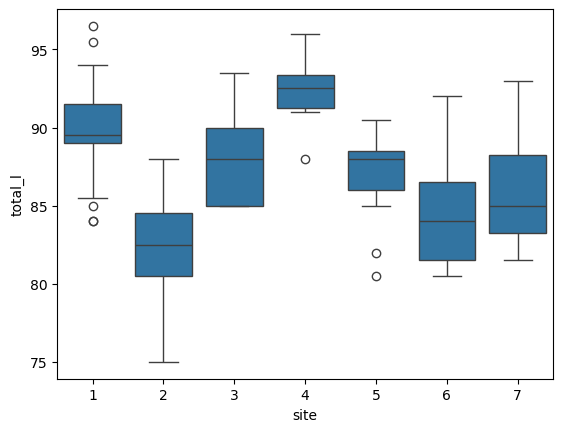

In [16]:
sns.boxplot(data = possum, x = 'site', y = 'total_l');

## Bonus: Interactions

To create interaction terms, you separate your variables by a `:` in the formula.

An interaction term is created by multiplying two variables together. It is a way that we can see if the effect of one variable is different for different levels of a categorical variable. 

For example, we can check to see if the effect of head length is different for male possums compared to female possums.

In [17]:
lr_full =sm.ols('total_l ~ head_l + sex + head_l:sex', data = possum).fit()
lr_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                total_l   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     42.94
Date:                Thu, 11 Sep 2025   Prob (F-statistic):           6.45e-18
Time:                        20:27:25   Log-Likelihood:                -255.98
No. Observations:                 104   AIC:                             520.0
Df Residuals:                     100   BIC:                             530.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -28.7222     15.976     -1.798      0.075     -60.419       2.974
sex[T.m]           45.0841     18.058      2.497      0.014       9.258      80.910
head_l              1.2657      0.173      7.303      0.000       0.922       1.610
head_l:sex[T.m]    -0.5107      0.196     -2.612      0.010      -0.899      -0.123
==============================================================================
Omnibus:                        0.056   Durbin-Watson:                   1.792
Prob(Omnibus):                  0.972   Jarque-Bera (JB):                0.156
Skew:                          -0.052   Prob(JB):                        0.925
Kurtosis:                       2.841   Cond. No.                     9.12e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

If we use the coefficients of the model to write out the equation for each sex, we get:

Female Possums: total_l = -28.7222 + 1.2657*(head_l)

Male Possums:  total_t = -28.7222 + 45.0841 + (1.2657 - 0.5107)*(head_l) = 16.3619 + 0.755*(head_l)

This shows that we have different intercepts and different slopes for each sex.

**Question:** Are the interaction terms significant?

**Null Hypothesis:** $\beta_{head\_l:sex} = 0$

**Alternative Hypothesis:** $\beta_{head\_l:sex} \neq 0$ 

In [18]:
lr_reduced =sm.ols('total_l ~ head_l + sex', data = possum).fit()
lr_full =sm.ols('total_l ~ head_l + sex + head_l:sex', data = possum).fit()

stats.stats.anova_lm(lr_reduced, lr_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,101.0,893.49296,0.0,NaN,NaN,NaN
1,100.0,836.41236,1.0,57.0806,6.824457,0.010377


Conclusion: The interaction term is significant.

## Bonus: Polynomial Regression

Let's revisit the cars dataset.

In [19]:
cars = pd.read_csv('../data/auto-mpg.csv')

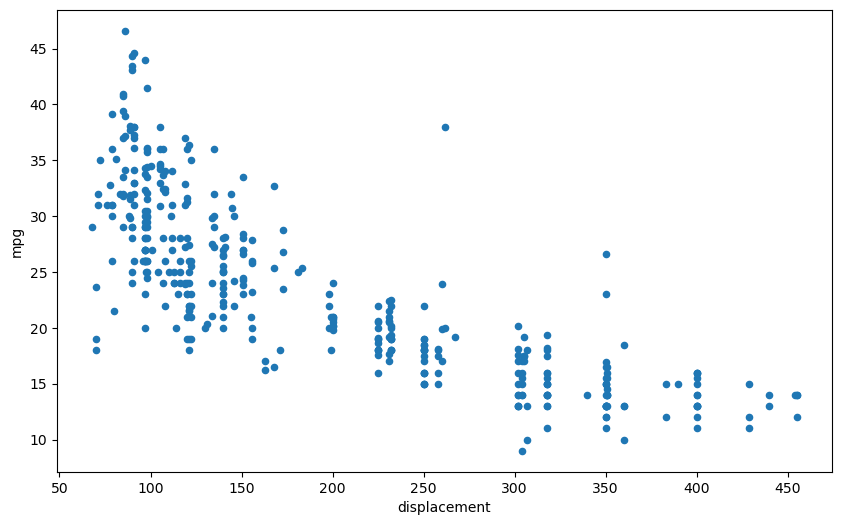

In [20]:
cars.plot(kind = 'scatter', x = 'displacement', y = 'mpg', figsize = (10,6));

We saw last time that when trying to fit a simple linear regression model, we saw a distinct pattern in the residuals. 

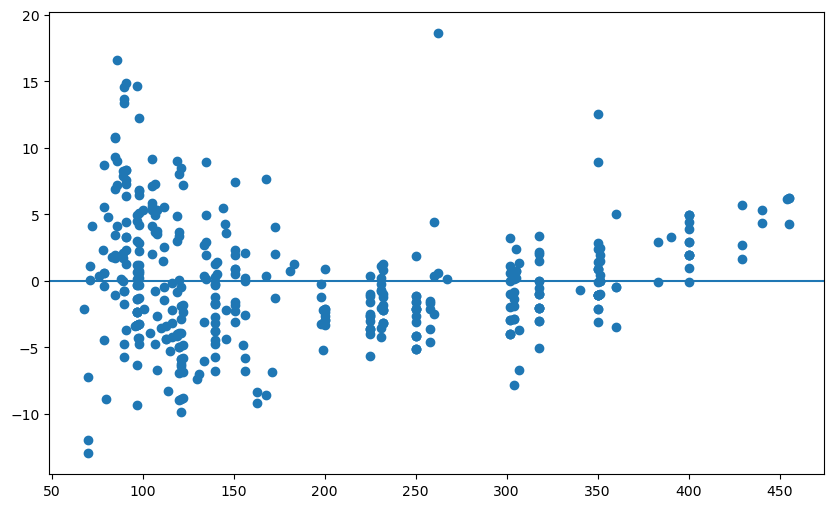

In [21]:
lr_cars = sm.ols('mpg ~ displacement', data = cars).fit()

plt.figure(figsize = (10,6))
plt.scatter(cars['displacement'], lr_cars.resid)
xmin, xmax = plt.xlim()
plt.hlines(y = 0, xmin = xmin, xmax = xmax)
plt.xlim(xmin, xmax);

It looks like the relationship is not linear, but instead is curved. We can try to capture this using a polynomial.

$$\text{mpg}_i = \beta_0 + \beta_1\cdot \text{displacement}_i + \beta_2 \cdot \text{(displacement)}^2_i + \epsilon_i$$ 

To let statsmodels know that we want a polynomial, we surround the formula with an I.

In [22]:
lr_poly = sm.ols('mpg ~ displacement + I(displacement**2)', data = cars).fit()
lr_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     436.3
Date:                Thu, 11 Sep 2025   Prob (F-statistic):          9.64e-101
Time:                        20:27:26   Log-Likelihood:                -1150.5
No. Observations:                 398   AIC:                             2307.
Df Residuals:                     395   BIC:                             2319.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               42.2089      1.073     39.347      0.000      40.100      44.318
displacement            -0.1394      0.011    -12.569      0.000      -0.161      -0.118
I(displacement ** 2)     0.0002   2.36e-05      7.267      0.000       0.000       0.000
==============================================================================
Omnibus:                       42.874   Durbin-Watson:                   0.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.239
Skew:                           0.552   Prob(JB):                     1.04e-22
Kurtosis:                       5.211   Cond. No.                     3.36e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Inspecting the residuals, it looks like we have removed the nonlinearity.

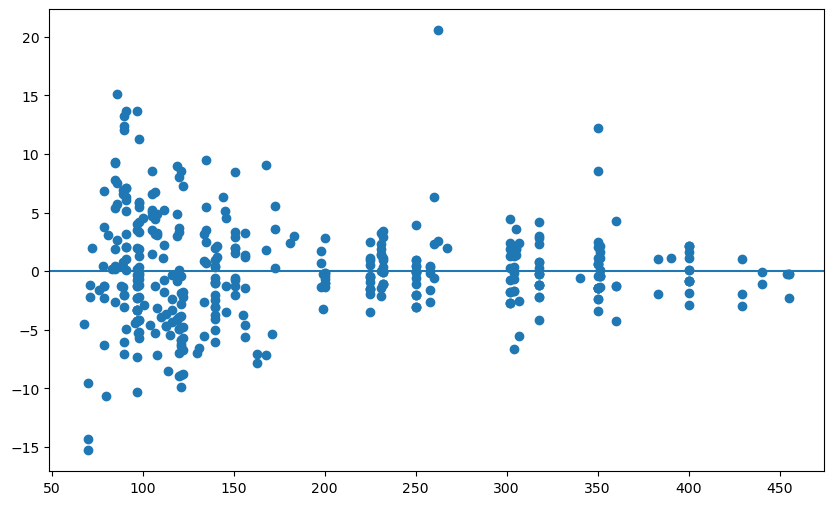

In [23]:
plt.figure(figsize = (10,6))
plt.scatter(cars['displacement'], lr_poly.resid)
xmin, xmax = plt.xlim()
plt.hlines(y = 0, xmin = xmin, xmax = xmax)
plt.xlim(xmin, xmax);

However, we have a different problem - it looks like the residuals don't have constant variance.

If we look at the residuals vs the fitted values, we can see that larger values of the response have higher variance.

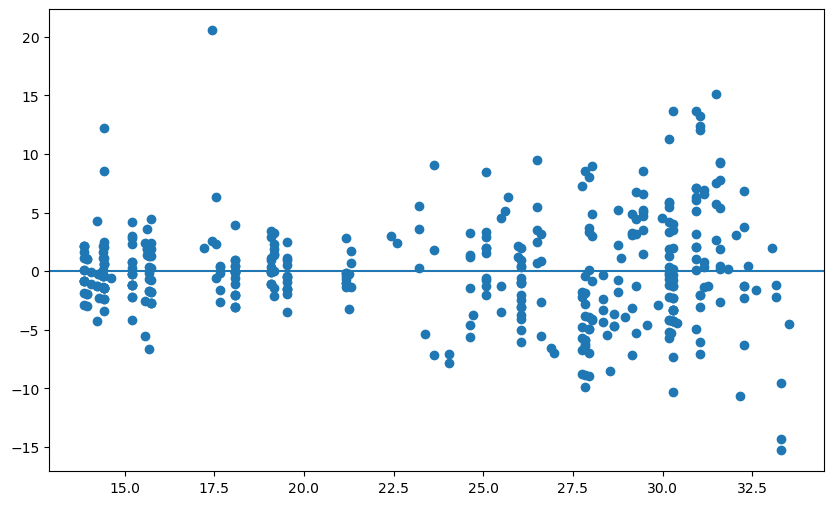

In [24]:
plt.figure(figsize = (10,6))
plt.scatter(lr_poly.fittedvalues, lr_poly.resid)
xmin, xmax = plt.xlim()
plt.hlines(y = 0, xmin = xmin, xmax = xmax)
plt.xlim(xmin, xmax);

A potential fix to this is to use the logarithm of the target.

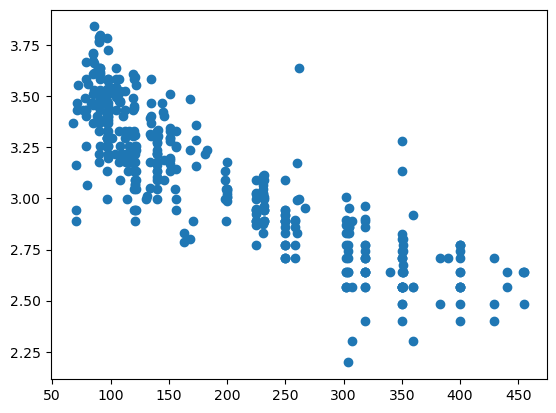

In [25]:
plt.scatter(x = cars['displacement'], y = np.log(cars['mpg']));

In [26]:
lr_poly_log = sm.ols('np.log(mpg) ~ displacement + I(displacement**2)', data = cars).fit()
lr_poly_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            np.log(mpg)   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     582.6
Date:                Thu, 11 Sep 2025   Prob (F-statistic):          1.50e-118
Time:                        20:27:27   Log-Likelihood:                 138.89
No. Observations:                 398   AIC:                            -271.8
Df Residuals:                     395   BIC:                            -259.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.8410      0.042     91.409      0.000       3.758       3.924
displacement            -0.0051      0.000    -11.625      0.000      -0.006      -0.004
I(displacement ** 2)  4.921e-06   9.25e-07      5.323      0.000     3.1e-06    6.74e-06
==============================================================================
Omnibus:                       17.826   Durbin-Watson:                   0.911
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.952
Skew:                           0.027   Prob(JB):                     1.05e-10
Kurtosis:                       4.664   Cond. No.                     3.36e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

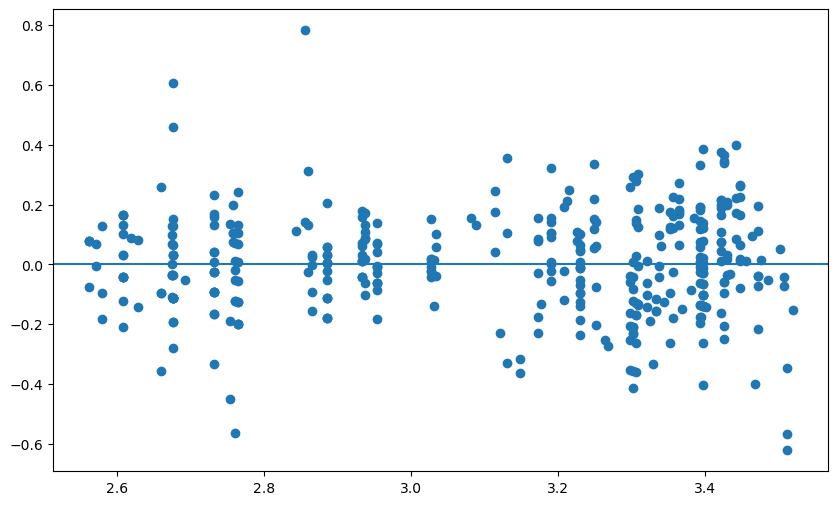

In [27]:
plt.figure(figsize = (10,6))
plt.scatter(lr_poly_log.fittedvalues, lr_poly_log.resid)
xmin, xmax = plt.xlim()
plt.hlines(y = 0, xmin = xmin, xmax = xmax)
plt.xlim(xmin, xmax);

In [28]:
from scipy.stats import probplot

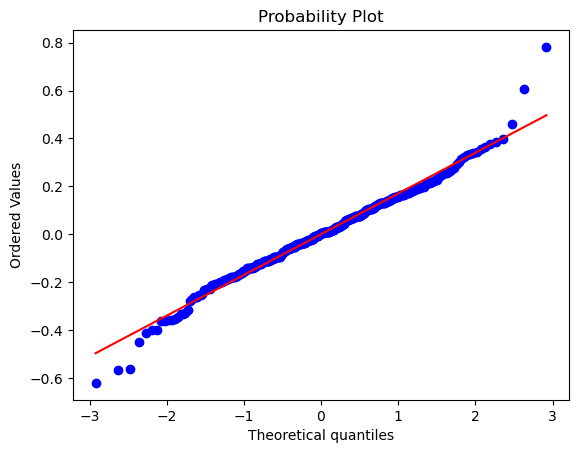

In [29]:
probplot(lr_poly_log.resid, plot=plt);

Now, let's see what the intervals look like.

Note that since our target is the logarithm of the mpg, we need to exponentiate our predictions.

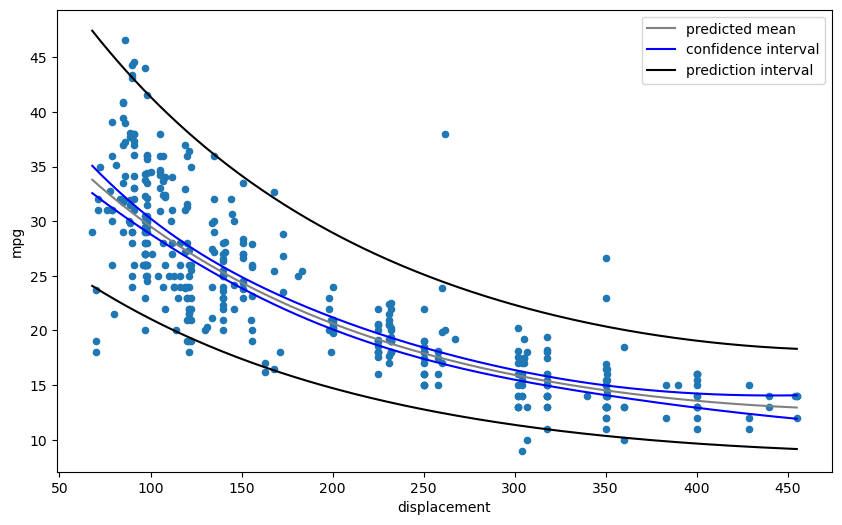

In [30]:
var = 'displacement'

x_pred = pd.DataFrame({
    var: np.linspace(start = cars[var].min(),
                               stop = cars[var].max(), num = 250)
})

pred = lr_poly_log.get_prediction(x_pred).summary_frame()

cars.plot(kind = 'scatter', x = var, y = 'mpg', figsize = (10,6))

plt.plot(x_pred[var], np.exp(pred['mean']), color = 'grey', label = 'predicted mean')

plt.plot(x_pred[var], np.exp(pred['mean_ci_lower']), color = 'blue', label = 'confidence interval')
plt.plot(x_pred[var], np.exp(pred['mean_ci_upper']), color = 'blue')

plt.plot(x_pred[var], np.exp(pred['obs_ci_lower']), color = 'black', label = 'prediction interval')
plt.plot(x_pred[var], np.exp(pred['obs_ci_upper']), color = 'black')

plt.legend();